Hello!

Today we are going to look at how we can create digitial twins of physical 'reservoir' computing systems i.e. physical systems that behave like recurrent neural networks. With the digital twins, we are then going to interconnect multiple different physical systems, and train the interconnections to optimise performance for a particular task.



For the purposes of this tutorial, I have created a few 'physical' devices which you can pretend are experimental systems that we can input data and measure the response. They are dynamic systems which have a history dependent response.




In [1]:
# Dependencies
import numpy as np
import torch
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)
from utils import Physical_Device
import pickle
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Might not need this.


Load in a particular device from the 'Devices' folder

In [2]:
filename = 'Devices/Device_3_Outputs_5_Noise_0.pkl'
with open(filename, 'rb') as file:
    loaded_device3 = pickle.load(file)
print("Device3 object loaded.")

Device3 object loaded.


The goal is to train a digital twin of a single or multiple devices and then us that to create a 'physical' neural network.

In order to train a digital twin for a particular device, we first need to gather some data.

The response for a particular device can be gathered as follows:


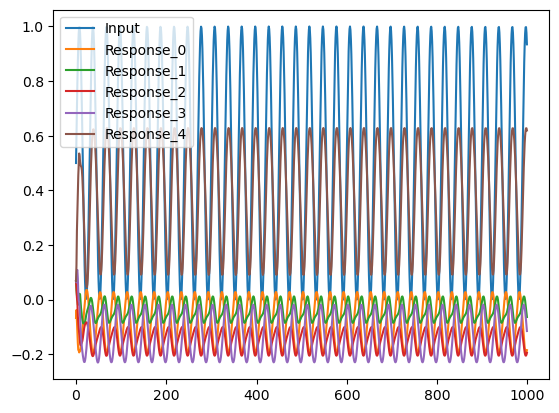

In [3]:
time_steps = np.linspace(0,1000,1000)

# Create a sine wave with a period of 30 which oscillates between 0 and 1 and use this as input.
period = 30
factor = 2*3.1415/period
input_ = np.sin(time_steps*factor)

#rescale between 0 and 1
input_ = (input_ - np.min(input_))/(np.max(input_)-np.min(input_))


## Input the data into the device.

def dataformat(input_):
    if len(input_.shape)==1:
        input_ = input_.reshape(len(input_),1)
    if len(input_.shape)==2:
        input_ = input_.reshape(np.max(input_.shape),1)
    return torch.transpose(torch.tensor(input_),0,1).unsqueeze(0)

# Convert time-series into correct format for device 
X = dataformat(input_)

#get the device response
response = loaded_device3.run_sequence(X)

#plot
plt.plot(input_,label = 'Input')
if response.shape[1]==1:
    plt.plot(response[0,0,:].numpy(), label='Response')
else:
    for i in range(response.shape[1]):
        plt.plot(response[0,i,:].numpy(), label='Response_{}'.format(i))
plt.legend()
plt.show()

Try loading some of the different devices and having a look at the responses.

Also have a play around with the input sequence. This can be anything bounded by 0 - 1.

In [102]:
## Your code to load other devices and different input sequences.

Now on to training a neural network to mimic the device behaviour. 

The goal here is to gather a sufficient dataset which explores the full dynamic regime and train a neural network to predict the response of the system.

First, create an input time-series which will sufficiently explore the dynamic range of the system 
Possibilities are periodic signals with varying frequencies, random signals etc. 

In [103]:
def input_set():
    # Insert code here to create a suitable input sequence (must be one dimensional).


    return input


X = dataformat(input_set())

#get the device response
response = loaded_device1.run_sequence(X)

#plot
plt.plot(input_,label = 'Input')
if response.shape[1]==1:
    plt.plot(response[0,0,:].numpy(), label='Response')
else:
    for i in range(response.shape[1]):
        plt.plot(response[0,i,:].numpy(), label='Response_{}'.format(i))
plt.legend()
plt.show()

AttributeError: 'function' object has no attribute 'shape'

Now that we have a good dataset with inputs and outputs, we need to define an appropriate neural network to mimic the device response. 

It doesnt matter what we chose, as long as its fundamental behaviour matches that of the dynamic system.

As a (bad) example, I will show how to do this with an MLP.

torch.Size([1000, 5])
Epoch [1/100], Loss: 0.2206
Epoch [2/100], Loss: 0.2073
Epoch [3/100], Loss: 0.1945
Epoch [4/100], Loss: 0.1823
Epoch [5/100], Loss: 0.1707
Epoch [6/100], Loss: 0.1596
Epoch [7/100], Loss: 0.1492
Epoch [8/100], Loss: 0.1392
Epoch [9/100], Loss: 0.1299
Epoch [10/100], Loss: 0.1210
Epoch [11/100], Loss: 0.1127
Epoch [12/100], Loss: 0.1049
Epoch [13/100], Loss: 0.0975
Epoch [14/100], Loss: 0.0906
Epoch [15/100], Loss: 0.0841
Epoch [16/100], Loss: 0.0780
Epoch [17/100], Loss: 0.0722
Epoch [18/100], Loss: 0.0667
Epoch [19/100], Loss: 0.0616
Epoch [20/100], Loss: 0.0568
Epoch [21/100], Loss: 0.0522
Epoch [22/100], Loss: 0.0479
Epoch [23/100], Loss: 0.0440
Epoch [24/100], Loss: 0.0402
Epoch [25/100], Loss: 0.0368
Epoch [26/100], Loss: 0.0336
Epoch [27/100], Loss: 0.0307
Epoch [28/100], Loss: 0.0280
Epoch [29/100], Loss: 0.0255
Epoch [30/100], Loss: 0.0233
Epoch [31/100], Loss: 0.0212
Epoch [32/100], Loss: 0.0194
Epoch [33/100], Loss: 0.0177
Epoch [34/100], Loss: 0.0162
E

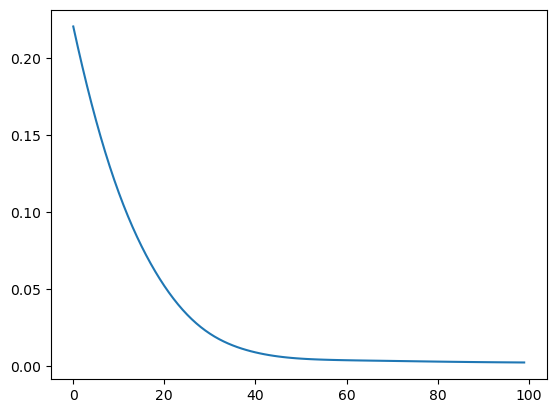

In [4]:
# Example MLP. The goal is, for a given sequence of inputs, we want to know what the outputs will be.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

T = 1000

response_flattened = response.permute(0, 2, 1).reshape(-1, response.shape[1])  # Outputs Reshape to [T, 5]
print(response_flattened.shape)
X_flattened = X.permute(0, 2, 1).reshape(-1, 1)  # Inputs Reshape to [T, 1]

dataset = TensorDataset(X_flattened, response_flattened)
# Create a data loader
batch_size = 1000
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
print(data_loader)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Instantiate the model, loss function, and optimizer
input_size = 1  # Input size is 1
hidden_size = 64  # You can adjust the hidden size
output_size = 5  # Output size is 5
model = MLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss/len(data_loader))
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(data_loader):.4f}')
plt.plot(losses)
plt.show()


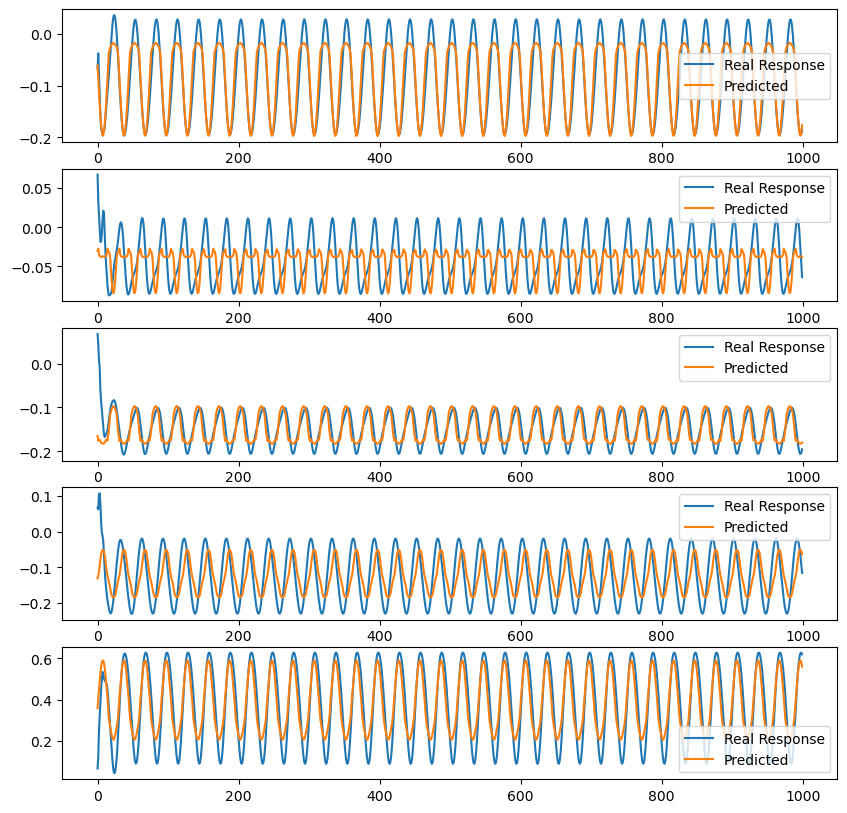

In [5]:
# Check the training performance
fig,ax=plt.subplots(5,1,figsize=(10,10))
for i in range(5):
    ax[i].plot(response_flattened[:,i],label='Real Response')
    ax[i].plot(outputs[:,i].detach().numpy(),label='Predicted')
    ax[i].legend()

We see that, as expected, the MLP does ok for some outputs, but very poorly for others as the MLP does not know about time-dependance.

Now, its your turn to pick a suitable architecture to mimic the system. Remember the model needs to account for history dependent responses.



In [ ]:
## Code here to insert your own model for training the system.

You should now (hopefully ;)) have a neural network 'digital twin' that can model the dynamics of a particular device. 

The goal now is to use this digitial twin to optimise / train some parameters of the device for a particular task.

The task we are going to look at first is a relatively simple future prediction task.

The dataset we are trying to predict is the Mackey-Glass dataset, a fairly standard benchmark dataset in physical computing. 

Here we want to predict the signal 10 steps into the future and we aere going to optimise the input scaling and bias to see if we can improve the performance ( I dont expect there to be much improvement, this is only to demoonstrate how we can transfer weights from the model to the device.)

First lets look at how a single device does without optimising 

In [6]:
filename = 'Devices/Device_3_Outputs_5_Noise_0.pkl'
with open(filename, 'rb') as file:
    loaded_device3 = pickle.load(file)
print("Device3 object loaded.")

Device3 object loaded.


torch.Size([1, 5, 1000])


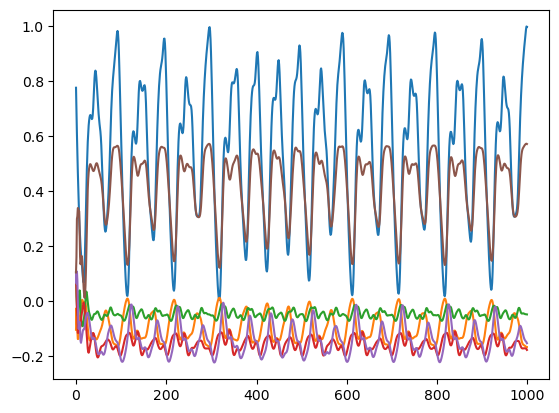

In [7]:
## Gather the data

data = np.load('mackey_glass_t17.npy')
data = (data-np.min(data))/(np.max(data)-np.min(data))
T = 1000

input_ = dataformat(data[:T])
plt.plot(input_[0,0,:])

response = loaded_device3.run_sequence(input_)
print(response.shape)
for i in range(response.shape[1]):
    plt.plot(response[0,i,:])

(998,)
(998, 5)


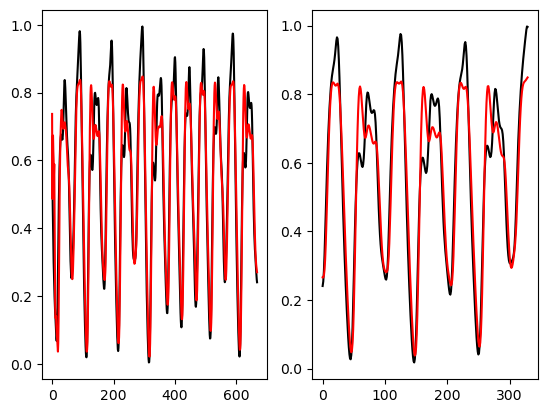

In [8]:
# Fit a linear layer to convert the device output to a prediction

# Define prediction target
future = 2

#Create target dataset
target = data[future:T]
device_outputs = response[0,:,:-future].numpy().T

print(target.shape)
print(device_outputs.shape)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse
X_train, X_test, y_train, y_test = train_test_split(
    device_outputs, target, test_size=0.33, shuffle=False)

ridge = Ridge(alpha=0.1)

ridge.fit(X_train,y_train)

Z_train = ridge.predict(X_train)
Z_test = ridge.predict(X_test)

MSE_tr = mse(y_train,Z_train)
MSE_te = mse(y_test,Z_test)

fig,ax = plt.subplots(1,2)
ax[0].plot(y_train,c='k')
ax[0].plot(Z_train,c='r')

ax[1].plot(y_test,c='k')
ax[1].plot(Z_test,c='r')


It does ok, but could be better.

Let's see if we can use the model to train the input weight and bias.

Create a method to optimise the input parameters, using the trained model to backprop and then transfer weights to the real system. You need to make sure that the weights in your model do not update during training.

Once you've optimised the parameters, you then need to transfer the learned input parameters onto the device.

In [ ]:
# Create a neural network with the digital twin


class digi_twin:
    def __init__(self,digi_twin):
        super().__init__()
        '''
        Add your own code here to define the input bias and scaling
        '''
        self.input_bias =  # parameter for input bias
        self.input_scaling = # parameter for input scaling
        self.digi_twin =  # define your digital twin that you trained earlier

    def forward(X):
        '''
        Add your own digitial twin here.
        '''
        X = X*self.input_bias + self.input_scaling

        # Run through digital twin
        ## your code here  - Rememember turn off weight updates for your model

        

## Code to test on the 'real' device

Hopefully you've seen that you can use the digital twin to train properties of the device. 

As the last step, you can now create larger networks of devices. Try create a multilayer architecture, where the output of one device is fed into another. You can use the same physical device multiple times in your network, or train digitial twins of multiple devices. The choice is yours.

You can start with the same task as before, or if thats too simple, feel free to define your own task. 

As you increase the number of layers in your network, does the performance continually improve, or does it reach a saturation point? 

In [ ]:
# Code here to create larger networks of physical devices.